In [15]:
import os
import warnings

import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms as T

from train import create_net

warnings.filterwarnings("ignore")

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
net = create_net(device, 1, 1, 'checkpoints/08-13_20_59_40/Net_best.pth')

[INFO]: **********************************************************************
Network: ResNet
	1 input channels
	1 output channels (classes)

[INFO]: Model loaded from checkpoints/08-13_20_59_40/Net_best.pth


/disk2/zsxm/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [42]:
net.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [38]:
transform = T.Compose([
    T.Resize(51), # 缩放图片(Image)，保持长宽比不变，最短边为img_size像素
    T.CenterCrop(51), # 从图片中间切出img_size*img_size的图片
    T.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]
    #T.Normalize(mean=[.5], std=[.5]) # 标准化至[-1, 1]，规定均值和标准差
])

In [85]:
img = Image.open('111.png')
img = transform(img).unsqueeze(0).to(device=device)
img.requires_grad_()
net.zero_grad()
pred_cate = net(img)
print(f'pred_cate:{pred_cate.item()}')
target = torch.tensor([[0]], dtype=torch.float32).to(device=device, dtype=torch.float32)
loss = F.binary_cross_entropy_with_logits(pred_cate, target)
print(f'loss:{loss.item()}')
loss.backward()
grad = img.grad.data.squeeze(0).permute(1, 2, 0).squeeze(2)

pred_cate:2.665471076965332
loss:2.732724666595459


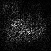

In [86]:
img_grad = torch.abs(grad)
img_grad = (img_grad / img_grad.max() * 255).type(torch.uint8)
img_grad = Image.fromarray(img_grad.cpu().numpy())
display(img_grad)

In [88]:
input_path='/nfs3-p1/zsxm/dataset/aorta_classify/0/'
error_0_list = []
for f in os.listdir(input_path):
    img = Image.open(os.path.join(input_path, f))
    img = transform(img).unsqueeze(0).to(device=device)
    with torch.no_grad():
        pred_cate = net(img)
        if pred_cate.item() > 0:
            print(f)
            error_0_list.append(f)
            
print(f'len of error 0:{len(error_0_list)}')

1_chenxiu_390.png
1_chenxiu_543.png
1_CTA2(-)_119.png
1_CTA2(-)_132.png
1_dingxing_293.png
1_dingxing_413.png
1_huanggaoqiang_135.png
1_huanggaoqiang_216.png
1_huanggaoqiang_217.png
1_huanggaoqiang_219.png
1_huanggaoqiang_391.png
1_louhangqing_133.png
1_louhangqing_136.png
1_louhangqing_371.png
1_louhangqing_413.png
1_louhangqing_426.png
1_louhangqing_505.png
1_louhangqing_506.png
1_louhangqing_515.png
1_louhangqing_541.png
1_louhangqing_547.png
1_louhangqing_548.png
1_louhangqing_579.png
1_louhangqing_580.png
1_louhangqing_581.png
1_wangxiaowei_145.png
1_wangxiaowei_146.png
1_wangxiaowei_276.png
1_wangxiaowei_458.png
1_wangxiaowei_461.png
1_wangxiaowei_467.png
1_wangxiaowei_473.png
1_wangxiaowei_577.png
1_wangxiaowei_603.png
1_wangxiaowei_611.png
1_wangxiaowei_637.png
1_wangxiaowei_644.png
1_wangxiaowei_645.png
1_yangxiangqin_164.png
1_yangxiangqin_326.png
1_yangxiangqin_66.png
1_zhaoqifeng_117.png
1_zhaoqifeng_118.png
1_zhaoqifeng_120.png
1_zhaoqifeng_131.png
1_zhaoqifeng_136.png
1_z

In [89]:
input_path='/nfs3-p1/zsxm/dataset/aorta_classify/1/'
error_1_list = []
for f in os.listdir(input_path):
    img = Image.open(os.path.join(input_path, f))
    img = transform(img).unsqueeze(0).to(device=device)
    with torch.no_grad():
        pred_cate = net(img)
        if pred_cate.item() < 0:
            print(f)
            error_1_list.append(f)
            
print(f'len of error 1:{len(error_1_list)}')

1_fuhuajin-Im29-126_221.png
1_fuhuajin-Im29-126_222.png
1_fuhuajin-Im29-126_223.png
len of error 1:3
